Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation. Getting some decent results after training on resampled data with large step-size.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [13]:
data_dir = pathlib.Path('/mnt/sdb/hyper-kvasir/labeled/')

config = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'complete',
    "resample": False,
    "neg_class": ['normal-cecum'],
    "outcast": None,
    # Model
    "model": 'resnet',
    "num_epochs": 30,
    "batch_size": 128,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": False,
    "early_stopping": False,
    "early_stopping_patience": 20,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    # Misc
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

fine_tune_from = 130
fine_tune_epochs = 30
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Directories:  ['hemorrhoids' 'barretts' 'esophagitis-a' 'esophagitis-b-d'
 'ulcerative-colitis-0-1' 'barretts-short-segment' 'cecum' 'pylorus'
 'retroflex-rectum' 'ulcerative-colitis-grade-2'
 'ulcerative-colitis-grade-1' 'bbps-2-3' 'bbps-0-1' 'ileum'
 'retroflex-stomach' 'normal-z-line' 'ulcerative-colitis-2-3'
 'impacted-stool' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps'
 'ulcerative-colitis-grade-3' 'ulcerative-colitis-1-2']

hemorrhoids                 :    6 | 0.06%
barretts                    :   41 | 0.38%
esophagitis-a               :  403 | 3.78%
esophagitis-b-d             :  260 | 2.44%
ulcerative-colitis-0-1      :   35 | 0.33%
barretts-short-segment      :   53 | 0.50%
cecum                       : 1009 | 9.46%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-grade-1  :  201 | 1.89%
bbps-2-3                    : 1148 | 10.77%
bbps-0-1                    :  646 | 6.

# Step 1
Train a teacher model on labeled images

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, UpSampling2D, BatchNormalization

### Create and compile the model

In [5]:
resnet_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=config["img_shape"]
)

In [6]:
# Freeze layers in resnet
resnet_model.trainable = True

# Define model
resnet50_model = Sequential()

resnet50_model.add(resnet_model)
resnet50_model.add(GlobalAveragePooling2D())
resnet50_model.add(Dense(params["num_classes"], activation=config["final_activation"]))

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [7]:
if config["verbosity"] > 0:
    resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 23)                47127     
Total params: 23,634,839
Trainable params: 23,581,719
Non-trainable params: 53,120
_________________________________________________________________


### Callbacks

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

In [9]:
# By using LearnignRateScheduler
initial_learning_rate = config["learning_rate"]
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if config["early_stopping"]: callbacks.append(earlystopp_cb)
if config["learning_schedule"]: callbacks.append(lr_schedule_cb)

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write(str(config))
f.close()

### Train the model

In [14]:
history = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

last_epoch = history.epoch[-1]+1

# Write history dictionary to text file
f = open(log_dir+"/history.txt","w")
f.write( str(history.history) )
f.close()

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/30
58/58 [==============================] - 6s 97ms/step - loss: 0.7996 - sparse_categorical_accuracy: 0.7105 - val_loss: 9.7687 - val_sparse_categorical_accuracy: 0.0833

Epoch 00002: LearningRateScheduler reducing learning rate to 0.005311355311355312.
Epoch 2/30
58/58 [==============================] - 5s 95ms/step - loss: 0.7220 - sparse_categorical_accuracy: 0.7416 - val_loss: 5.1960 - val_sparse_categorical_accuracy: 0.1035

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0036159600997506237.
Epoch 3/30
58/58 [==============================] - 6s 95ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.7691 - val_loss: 4.6512 - val_sparse_categorical_accuracy: 0.1191

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00274102079395085.
Epoch 4/30
58/58 [==============================] - 5s 94ms/step - loss: 0.5421 - sparse_categorical_

`Keras`
Save/load the model

In [ ]:
# resnet50_model.save('models/{}.h5'.format(model_name+best_acc))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name+"94"))
# resnet50_model = tf.keras.models.load_model("/home/henrik/master_thesis/code/hyper-kvasir/models/best_cp-010.hdf")

## Evaluate the model

In [15]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/evaluate.txt","w")
f.write( str(resnet50_evaluate) )
f.close()

12/12 - 0s - loss: 0.3710 - sparse_categorical_accuracy: 0.9095


In [16]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

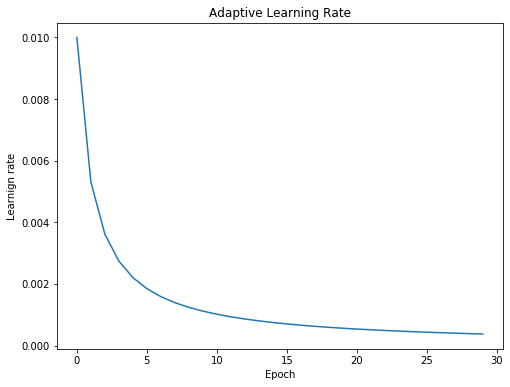

In [17]:
# Plot the learning rate
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learnign rate')
plt.savefig(log_dir+'/learning_rate.png')
plt.title('Adaptive Learning Rate');

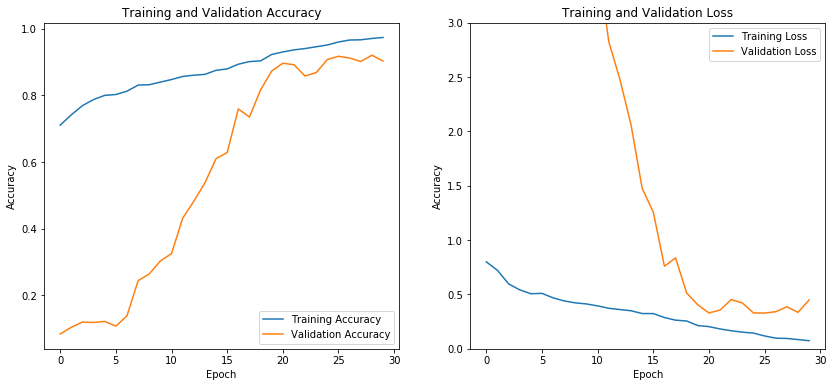

In [18]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.png')
plt.show()

### Fine tune the model

In [ ]:
res_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(res_net.layers))

# Freeze all the layers before the `fine_tune_at` layer
for layer in res_net.layers[:fine_tune_from]:
    layer.trainable = False

print("Number of layers unfreezed: ", len(resnet50_model.trainable_variables))

In [ ]:
# Drop learning rate by a magnitude
initial_learning_rate = config["learning_rate"]/10

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
callbacks = [tensorboard_cb, lr_schedule_cb]

In [ ]:
if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
total_epochs = last_epoch + fine_tune_epochs

history_fine = resnet50_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = total_epochs,
    initial_epoch = last_epoch,
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

last_epoch = history_fine.epoch[-1]+1

In [ ]:
# For fine-tuning
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

lr += history_fine.history['lr']

In [ ]:
# Plot the learning rate
plt.figure(figsize=(13, 4))
plt.plot(range(last_epoch), lr, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learnign rate')
plt.savefig(log_dir+'/learning_rate.png')
plt.title('Adaptive Learning Rate');

# Subplot 1
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([history.epoch[-1]-1,history.epoch[-1]-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

print ("Fine tuning from epoch: ", history.epoch[-1])

`Tensorboard`

#### Check the predictions on validation dataset

label: retroflex-rectum
1/1 [==============================] - 0s 14ms/sample
0.00% hemorrhoids
0.00% barretts
0.00% esophagitis-a
0.00% esophagitis-b-d
0.00% ulcerative-colitis-0-1
0.00% barretts-short-segment
0.00% cecum
0.00% pylorus
99.75% retroflex-rectum
0.00% ulcerative-colitis-grade-2
0.00% ulcerative-colitis-grade-1
0.00% bbps-2-3
0.00% bbps-0-1
0.00% ileum
0.18% retroflex-stomach
0.00% normal-z-line
0.00% ulcerative-colitis-2-3
0.00% impacted-stool
0.06% polyps
0.00% dyed-resection-margins
0.01% dyed-lifted-polyps
0.00% ulcerative-colitis-grade-3
0.00% ulcerative-colitis-1-2


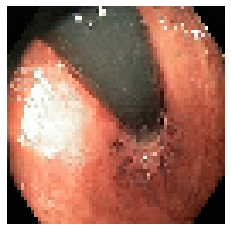

In [30]:
# Take one batch of validation data
for images, labels in val_ds.take(1):
    # Take one image and convert it to numpy
    img = images.numpy()[0]
    lab = labels.numpy()[0]
    # Add one dimension
    print ("label:", class_names[lab])
    show_image(img)
    img = np.expand_dims(img, 0)
    
    prediction = resnet50_model.predict(img, verbose=1)
    for i, pred in enumerate(prediction[0]):
        print("{:0.2f}% {}".format(pred*100, class_names[i]))